# 라이브러리

In [1]:
# 일반
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
from tqdm import tqdm
import glob
import warnings

# 머신 러닝
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import lightgbm

warnings.filterwarnings(action='ignore')
plt.style.use('ggplot')

c:\Users\mook\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mook\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\mook\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 데이터 불러오기 및 EDA

In [2]:
file_name = glob.glob('data/*.csv')
file_name = sorted(file_name)
file_name

['data\\test.csv', 'data\\train.csv']

In [3]:
train = pd.read_csv(file_name[1])
test = pd.read_csv(file_name[0])

display(train.tail())
display(test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 승객 아이디로 인덱스 설정
train = train.set_index(keys='PassengerId', drop=True).copy()
test = test.set_index(keys='PassengerId', drop=True).copy()

In [5]:
# train 데이터 info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
# 결측치 확인
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

* Age, Cabin, Embarked 결측치 존재

In [7]:
# 수치형 데이터 describe
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Survived, Pclass, SibSp, Parch 는 사실 범주형인 듯

In [8]:
# 문자형 데이터 describe
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


* Sex, Embarked 도 범주형으로 변환 가능할 듯

In [9]:
# 요약 함수 만들기
def summarize(data):
    summary = pd.DataFrame()
    
    summary['count'] = data.count()
    summary['nunique'] = data.nunique()
    summary['null'] = data.isna().sum()
    summary['freq'] = data.mode().iloc[0]
    summary['min'] = data.describe().T['min']
    summary['median'] = data.describe().T['50%']
    summary['mean'] = data.describe().T['mean']
    summary['max'] = data.describe().T['max']
    
    return summary

In [10]:
# train 데이터 요약
summarize(train)

,count,nunique,null,freq,min,median,mean,max
Survived,891,2,0,0.0,0.00,0.0000,0.383838,1.0000
Pclass,891,3,0,3.0,1.00,3.0000,2.308642,3.0000
Name,891,891,0,"Abbing, Mr. Anthony",NaN,NaN,NaN,NaN
Sex,891,2,0,male,NaN,NaN,NaN,NaN
Age,714,88,177,24.0,0.42,28.0000,29.699118,80.0000
SibSp,891,7,0,0.0,0.00,0.0000,0.523008,8.0000
Parch,891,7,0,0.0,0.00,0.0000,0.381594,6.0000
Ticket,891,681,0,1601,NaN,NaN,NaN,NaN
Fare,891,248,0,8.05,0.00,14.4542,32.204208,512.3292
Cabin,204,147,687,B96 B98,NaN,NaN,NaN,NaN


In [11]:
# test 데이터 요약
summarize(test)

,count,nunique,null,freq,min,median,mean,max
Pclass,418,3,0,3.0,1.00,3.0000,2.265550,3.0000
Name,418,418,0,"Abbott, Master. Eugene Joseph",NaN,NaN,NaN,NaN
Sex,418,2,0,male,NaN,NaN,NaN,NaN
Age,332,79,86,21.0,0.17,27.0000,30.272590,76.0000
SibSp,418,7,0,0.0,0.00,0.0000,0.447368,8.0000
Parch,418,8,0,0.0,0.00,0.0000,0.392344,9.0000
Ticket,418,363,0,PC 17608,NaN,NaN,NaN,NaN
Fare,417,169,1,7.75,0.00,14.4542,35.627188,512.3292
Cabin,91,76,327,B57 B59 B63 B66,NaN,NaN,NaN,NaN
Embarked,418,3,0,S,NaN,NaN,NaN,NaN


In [12]:
# train, test 데이터 중 수치형인 컬럼 뽑아내기
test_graph_cols = test.select_dtypes(include='number').columns.tolist()
train_graph_cols = test_graph_cols.copy()
train_graph_cols.append('Survived')

0it [00:00, ?it/s]

2it [00:00,  2.26it/s]


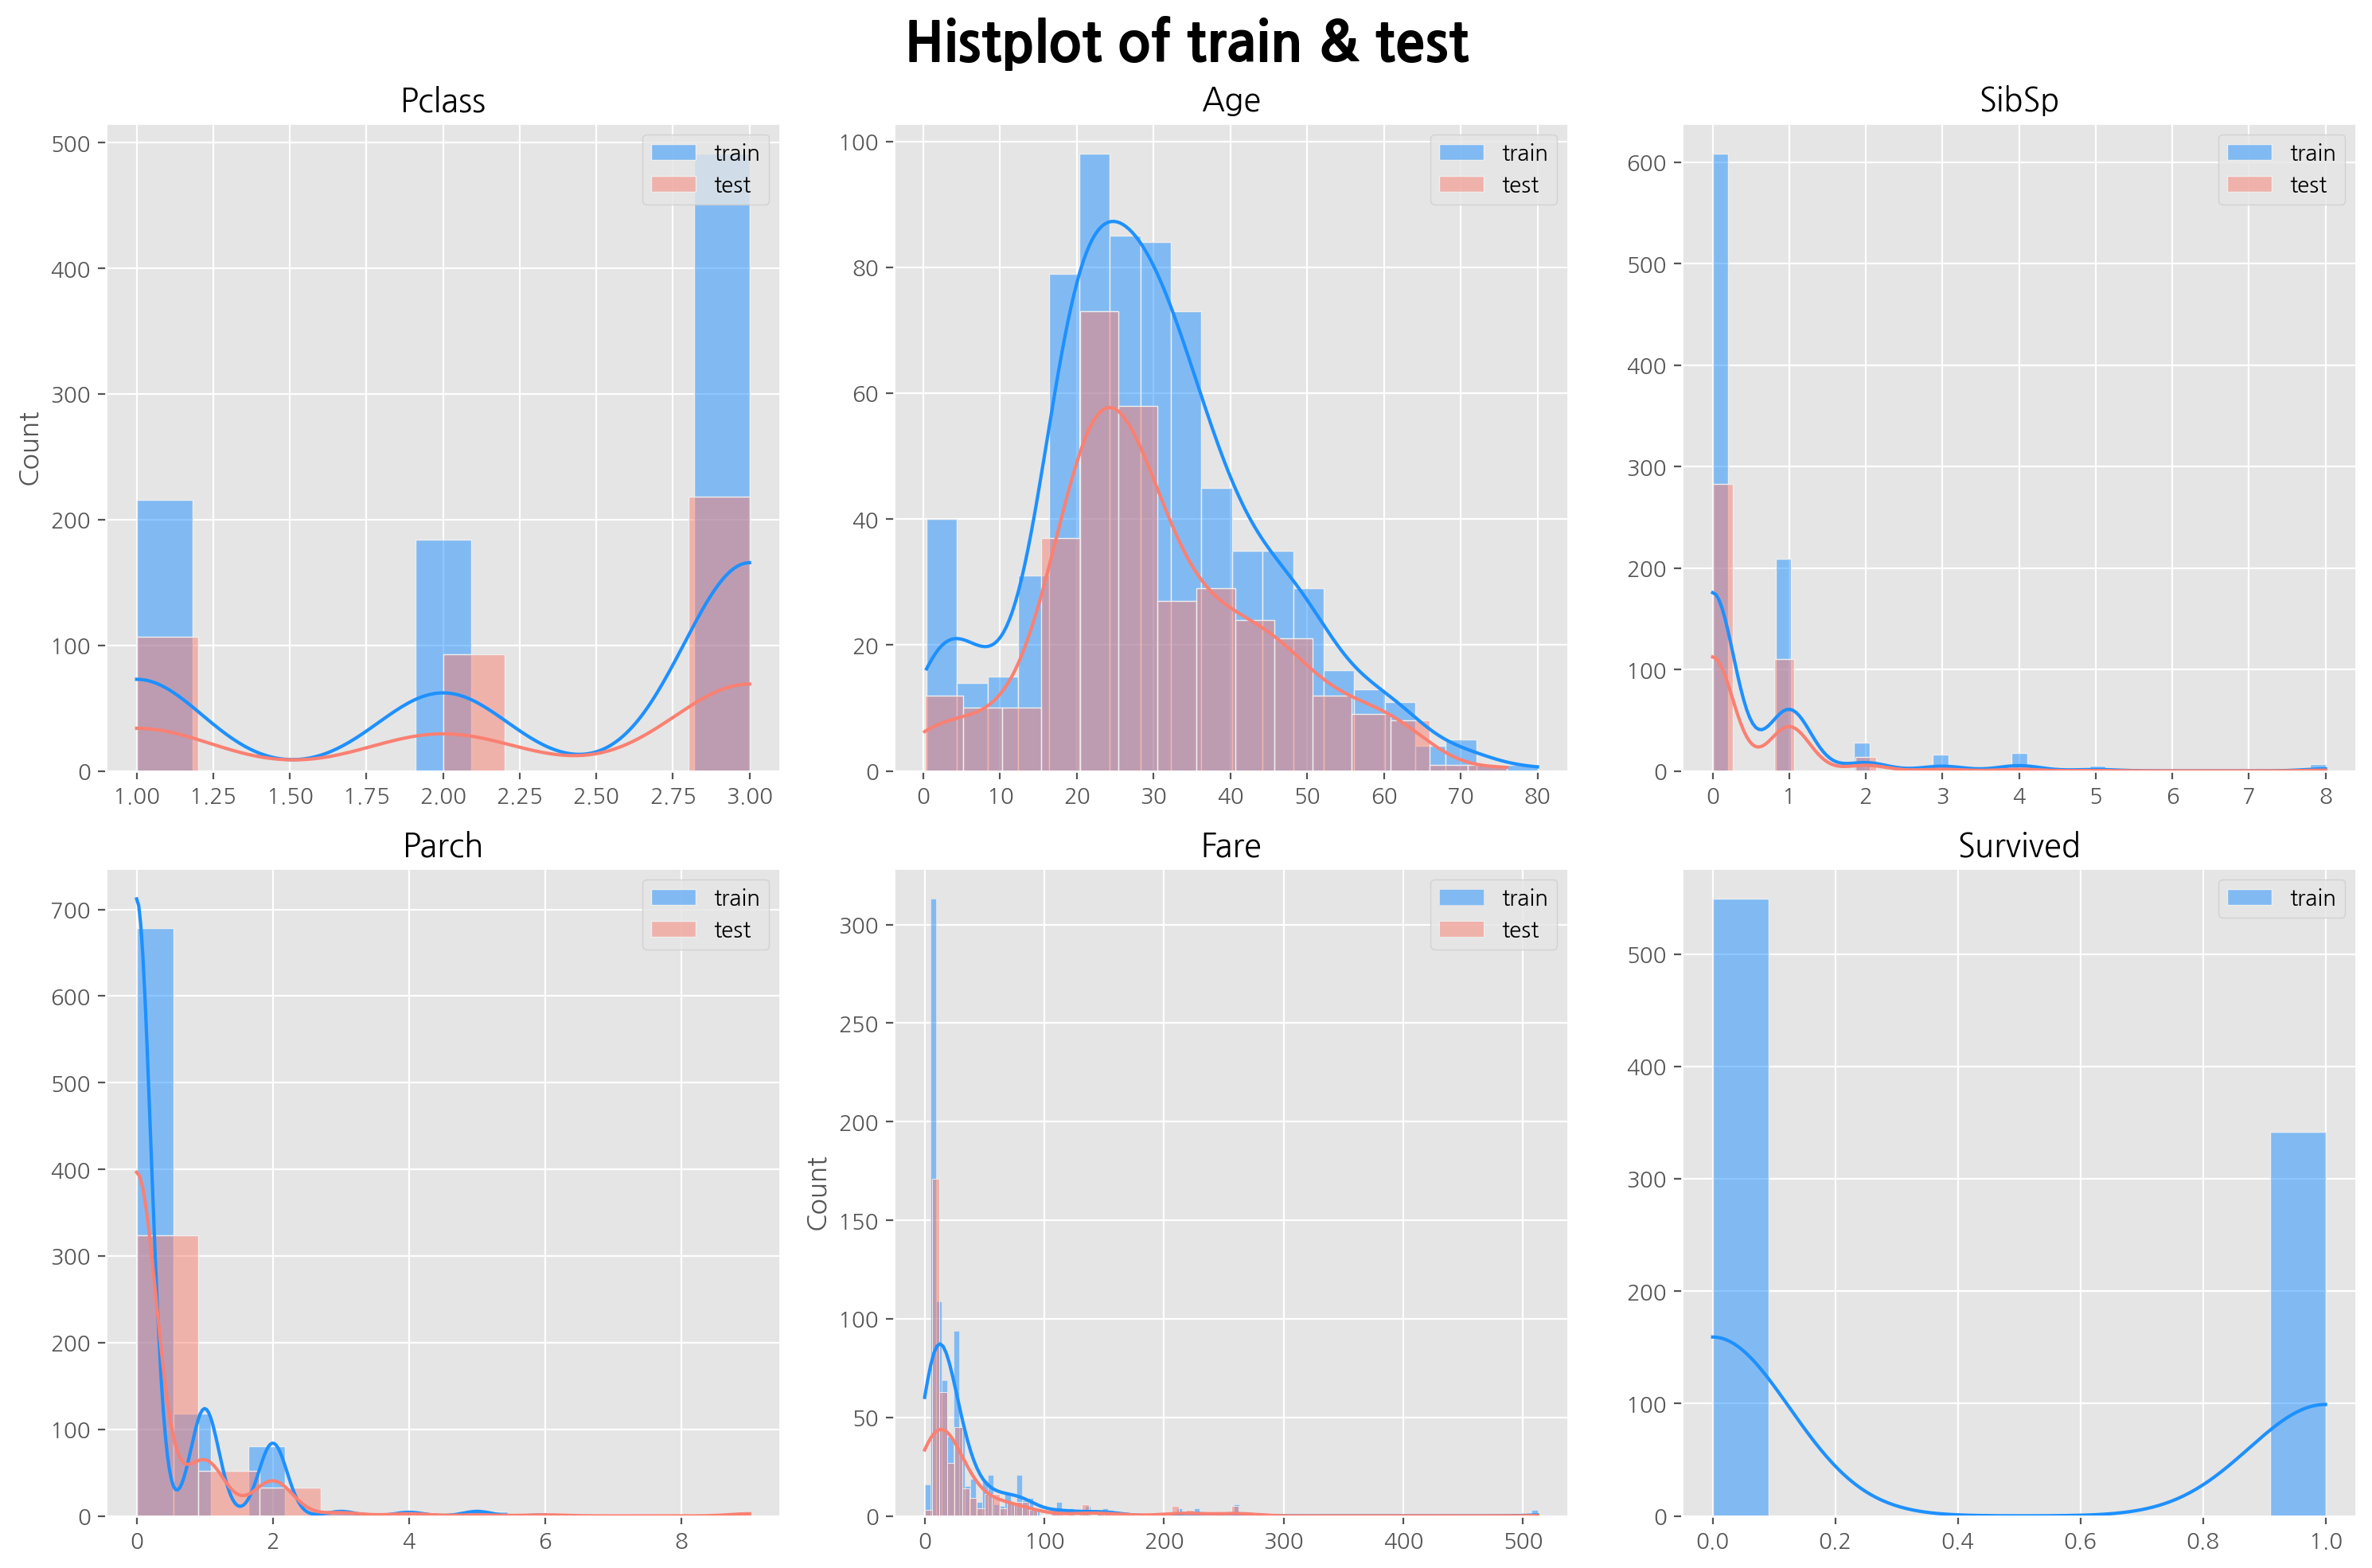

In [13]:
# train, test 수치형 데이터 분포 비교
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
ax = ax.flatten()

palette = ['dodgerblue', 'salmon']
labels = ['train', 'test']

for i, graph in tqdm(enumerate([train[train_graph_cols], test[test_graph_cols]])):
    for j, col in enumerate(graph.columns):
        
        sns.histplot(data=graph,
                     x=col,
                     ax=ax[j],
                     alpha=0.5,
                     color=palette[i],
                     kde=True,
                     label=labels[i])
        
        ax[j].legend(loc='upper right')
        
        if j % 4 != 0:
            ax[j].set_ylabel('')
        
        ax[j].set_xlabel('')
        ax[j].set_title(col)
    
    fig.suptitle('Histplot of train & test', fontsize=25, weight='bold')
    fig.tight_layout()

* 데이터 분포가 대체적으로 비슷함을 알 수 있다.
* => 트리 계열 모델을 사용할 예정이니, 표준화 같은 걸 따로 하지 않아도 될 듯

<Axes: >

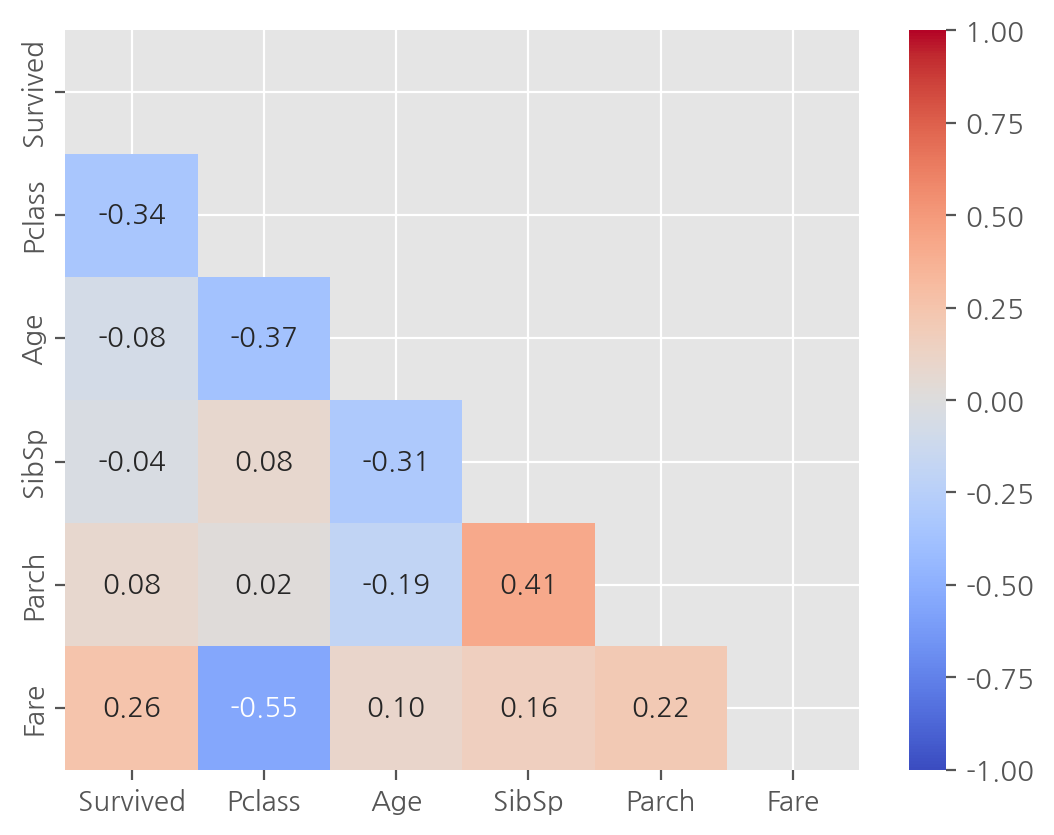

In [14]:
# 상관관계 보기
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(data=train.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmax=1, vmin=-1, mask=mask)

# 전처리
* Age, Cabin, Embarked 결측치 채우기
    * **Age** -> Name 에서 Mr, Mrs, Miss 등의 정보 + Parch 컬럼 정보를 기준으로 성인과 미성년으로 나누고 각각의 분포를 보고 평균, 혹은 중앙값으로 대체
    * **Cabin** -> Pclass 와 Fare 기준으로 결측치 채워볼 수 있을 듯 그리고 중요한 것은 A, B, C .. 가 중요한 것이므로 뒤에 숫자는 날려보기
    * **Embarked** -> 다른 정보를 기준으로 결측치 채우기
<br>
<br>
* Sex, Embarked 도 범주형으로 변환 가능할 듯
  * 각각 one-hot encoding 하기

## Age 결측치 채우기

4it [00:00, 12.32it/s]


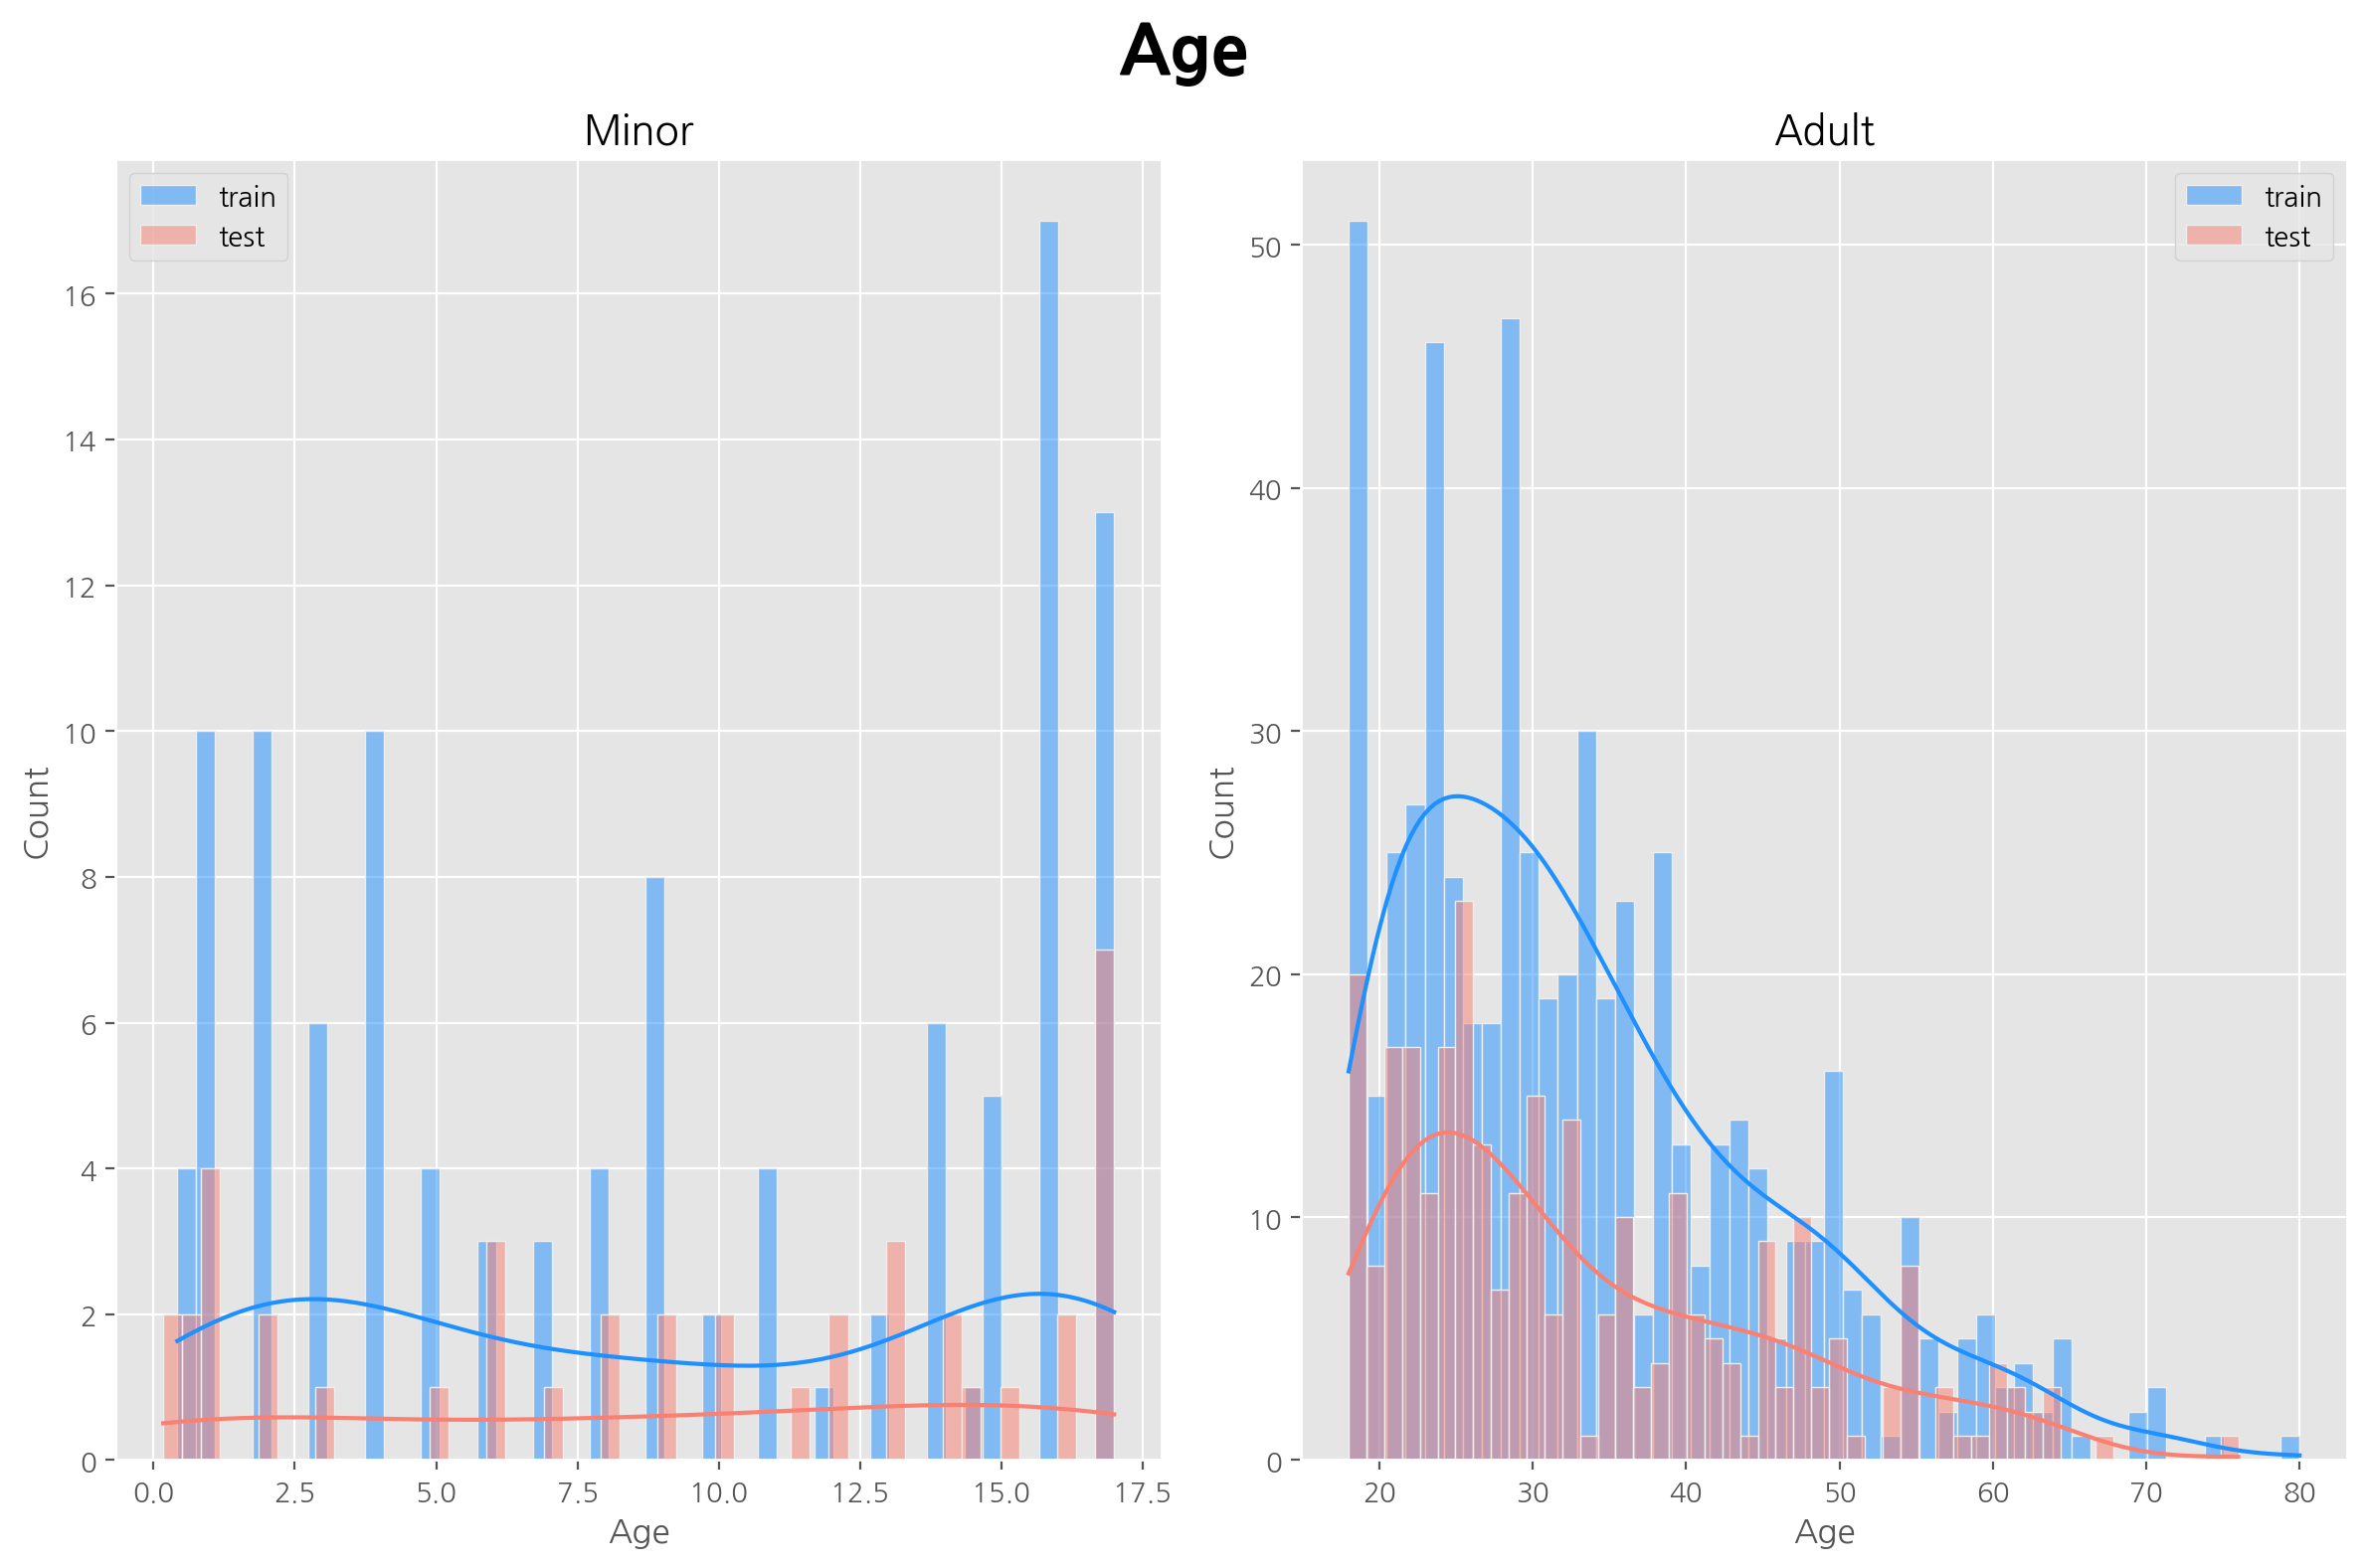

In [15]:
# train 미성년자, 성인
train_minor, train_adult = train[train['Age'] < 18], train[train['Age'] >= 18]
# test 미성년자, 성인
test_minor, test_adult = test[test['Age'] < 18], test[test['Age'] >= 18]

# train, test 의 미성년자, 성인의 Age 분포 확인
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
ax = axs.flatten()

palette = ['dodgerblue', 'dodgerblue', 'salmon', 'salmon']
labels = ['train', 'train', 'test', 'test']

for i, graph in tqdm(enumerate([train_minor, train_adult, test_minor, test_adult])):
    sns.histplot(
        data=graph,
        x='Age',
        ax=ax[i % 2],
        alpha=0.5,
        color=palette[i],
        kde=True,
        label=labels[i],
        bins=50
    )
    if i % 2 == 0:
        ax[i % 2].set_title('Minor')
        
    else:
        ax[i % 2].set_title('Adult')

    ax[i % 2].legend()
    
fig.suptitle('Age', fontsize=25, weight='bold')
fig.tight_layout()


* => 성인의 경우 정규 분포 형태가 아니므로 중앙값으로 대체하기
* 미성년자는 평균이나 중앙값 둘 중 어떤 걸로 해도 상관없을 것 같다. (미성년자라는 것이 중요하기 때문)

In [16]:
# train 데이터의 미성년자의 나이 평균, 성인의 중앙값 구하기
train_minor_mean, train_adult_median = train_minor['Age'].mean(), train_adult['Age'].median()

# test 데이터의 미성년자의 나이 평균, 성인의 중앙값 구하기
test_minor_mean, test_adult_median = test_minor['Age'].mean(), test_adult['Age'].median()

In [17]:
# Name 에서 호칭만 가져오기
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0] if len(x.split(',')) > 1 else '')
# 가져온 호칭에서 맨 앞의 ' '제거
train['Title'] = train['Title'].apply(lambda x : str(x)[1:])

# Name 에서 호칭만 가져오기
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0] if len(x.split(',')) > 1 else '')
# 가져온 호칭에서 맨 앞의 ' '제거
test['Title'] = test['Title'].apply(lambda x : str(x)[1:])

In [18]:
# train, 호칭 목록 확인
print(train['Title'].unique())

# test, 호칭 목록 확인
print(test['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


* 'Mr.': 결혼한 남성에게 사용되는 호칭으로, 'Mister'의 약어입니다.
* 'Mrs.': 결혼한 여성에게 사용되는 호칭으로, 'Missus'의 약어입니다.
* 'Miss.': 결혼하지 않은 여성에게 사용되는 호칭입니다.
* 'Master.': 어린 남성에게 사용되는 호칭입니다.
* 'Don.': 스페인어에서 사용되는 여성 호칭으로, "부인"이나 "여성"을 의미합니다.
* 'Rev.': 목사에게 사용되는 호칭으로, 'Reverend'의 약어입니다.
* 'Dr.': 의사에게 사용되는 호칭으로, 'Doctor'의 약어입니다.
* 'Mme.': 프랑스어에서 사용되는 여성 호칭으로, "여사"를 의미합니다.
* 'Ms.': 여성의 결혼 상태를 반영하지 않는 호칭입니다.
* 'Major.': 중령에게 사용되는 호칭입니다.
* 'Lady.': 상류층 여성에게 사용되는 호칭입니다.
* 'Sir.': 상류층 남성에게 사용되는 호칭입니다.
* 'Mlle.': 프랑스어에서 사용되는 여성 호칭으로, "마드모아젤"을 의미합니다.
* 'Col.': 대령에게 사용되는 호칭입니다.
* 'Capt.': 대위에게 사용되는 호칭으로, 'Captain'의 약어입니다.
* 'the': 특정한 의미를 가지지 않는 단어로, 다른 호칭과 함께 사용될 때에는 일반적으로 호칭 뒤에 오게 됩니다.
* 'Jonkheer.': 네덜란드에서 사용되는 남성 호칭으로, 상류층을 나타냅니다.
* 'Dona.': 스페인어와 포르투갈어에서 사용되는 여성 호칭으로, "부인"이나 "여성"을 의미합니다.

In [19]:
# 데이터 프레임 전체 열 보기
# pd.set_option('display.max_rows', None)

In [20]:
# train, Age 가 결측치인 데이터의 Title 목록 확인
print(train[train['Age'].isnull()]['Title'].unique())

# test, Age 가 결측치인 데이터의 Title 목록 확인
print(test[test['Age'].isnull()]['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Dr']
['Mr' 'Mrs' 'Miss' 'Ms' 'Master']


In [21]:
# train
# Master 는 어린 남성을 나타내는 말이므로 train 미성년자의 Age 평균으로 대체
train.loc[train['Title'] == 'Master', 'Age'] = train_minor_mean
# Dr 은 의사를 나타내는 말이므로 train 성인의 Age 중앙값으로 대체
train.loc[train['Title'] == 'Dr', 'Age'] = train_adult_median
# Mrs 는 결혼한 여성을 나타내는 말이므로 train 성인의 Age 중앙값으로 대체
train.loc[train['Title'] == 'Mrs', 'Age'] = train_adult_median

# test
# Master 는 어린 남성을 나타내는 말이므로 test 미성년자의 Age 평균으로 대체
test.loc[test['Title'] == 'Master', 'Age'] = test_minor_mean
# Dr 은 의사를 나타내는 말이므로 test 성인의 Age 중앙값으로 대체
test.loc[test['Title'] == 'Dr', 'Age'] = test_adult_median
# Mrs 는 결혼한 여성을 나타내는 말이므로 test 성인의 Age 중앙값으로 대체
test.loc[test['Title'] == 'Mrs', 'Age'] = test_adult_median

* Mr, Miss, Ms 는 미성년자일 수도 성인일 수도 있으므로 Parch 정보 확인

In [22]:
# train 데이터
print(train[train['Age'].isnull()]['Parch'].unique())

# test 데이터
print(test[test['Age'].isnull()]['Parch'].unique())

[0 1 2]
[0 2 9]


In [23]:
# train, Parch == 0 이면 미성년자가 혼자 탔을리 없으므로 성인으로 가정
train.loc[train['Parch'] == 0, 'Age'] = train_adult_median

# test, Parch == 0 이면 미성년자가 혼자 탔을리 없으므로 성인으로 가정
test.loc[test['Parch'] == 0, 'Age'] = test_adult_median

In [24]:
# train, 남아 있는 결측치 확인
display(train[train['Age'].isnull()])

# test, 남아 있는 결측치 확인
display(test[test['Age'].isnull()])

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,Miss
181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Miss
202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S,Mr
230,0,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S,Miss
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S,Mr
410,0,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,NaN,S,Miss
486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S,Miss
594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q,Miss
784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.4500,NaN,S,Mr


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1080,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S,Miss
1234,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S,Mr


In [25]:
# train
# Parch 와 SibSp 가 모두 1명이라도 있다면 누군가의 자녀라고 판단, 미성년으로 가정
train.loc[(train['SibSp'] > 0) & (train['Parch'] > 0), 'Age'] = train_minor_mean
# Parch 만 있고 SibSp 가 없다면 부모라고 판단, 성인으로 가정
train.loc[(train['SibSp'] == 0) & (train['Parch'] > 0), 'Age'] = train_adult_median

# test
# Parch 와 SibSp 가 모두 1명이라도 있다면 누군가의 자녀라고 판단, 미성년으로 가정
test.loc[(test['SibSp'] > 0) & (test['Parch'] > 0), 'Age'] = test_minor_mean
# Parch 만 있고 SibSp 가 없다면 부모라고 판단, 성인으로 가정
test.loc[(test['SibSp'] == 0) & (test['Parch'] > 0), 'Age'] = test_adult_median

In [26]:
# float 타입 int 로 변환
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

In [27]:
# Age 결측치 확인
print(train['Age'].isnull().sum())
print(test['Age'].isnull().sum())

0
0


## Embarked 결측치 채우기

In [28]:
# train 결측치 확인
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,31,0,0,113572,80.0,B28,NaN,Miss
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,31,0,0,113572,80.0,B28,NaN,Mrs


In [29]:
# 최빈값 확인
train['Embarked'].mode()[0]

'S'

In [30]:
# 최빈값으로 대체
train.loc[train['Embarked'].isnull(), 'Embarked'] = 'S'

In [31]:
# Embarked 결측치 확인
print(train['Embarked'].isnull().sum())
print(test['Embarked'].isnull().sum())

0
0


## Fare 결측치 대체

In [32]:
# test 결측치 확인
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,30,0,0,3701,NaN,NaN,S,Mr


In [33]:
# Pclass 의 평균으로 대체
fare_subtitute = test.loc[test['Pclass'] == 3, 'Fare'].mean()
test.loc[test['Fare'].isnull(), 'Fare'] = fare_subtitute

In [34]:
# Fare 결측치 확인
print(train['Fare'].isnull().sum())
print(test['Fare'].isnull().sum())

0
0


# Cabin 결측치 채우기

* Cabin 에서 객실 번호까지 예측하기도 힘들 뿐더러, 객실 위치가 중요하므로 객실 위치만 뽑아내기
* 다른 컬럼들을 활용해서 Cabin 결측치 채우기

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
 11  Title     891 non-null    object 
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 87.0+ KB


In [36]:
# 문자형 컬럼
cat_col = ['Sex', 'Embarked', 'Title']

In [37]:
# 문자형 -> 카테고리 타입으로 변환
train[cat_col] = train[cat_col].astype('category')
test[cat_col] = test[cat_col].astype('category')

In [38]:
# train, Cabin 이 두개씩 등록된 사람은 제일 처음 것 하나로 변경
train.loc[~train['Cabin'].isnull(), 'Cabin'] = train.loc[~train['Cabin'].isnull(), 'Cabin'].apply(lambda x : x.split()[0] if len(x) > 1 else '')

# test, Cabin 이 두개씩 등록된 사람은 제일 처음 것 하나로 변경
test.loc[~test['Cabin'].isnull(), 'Cabin'] = test.loc[~test['Cabin'].isnull(), 'Cabin'].apply(lambda x : x.split()[0] if len(x) > 1 else '')

In [39]:
# train, 객실 위치만 뽑아내기
train['Location'] = train['Cabin'].str[:1]

# test, 객실 위치만 뽑아내기
test['Location'] = test['Cabin'].str[:1]

In [40]:
# Locatin 예측에 사용할 컬럼
loc_cols = [
    'Pclass', 'Sex', 'Age', 'SibSp',
    'Parch', 'Fare', 'Embarked', 'Title'
    ]

In [41]:
# train Location 예측에 사용할 train, test, 정답값
train_train_loc = train[~train['Location'].isnull()][loc_cols]
train_test_loc = train[train['Location'].isnull()][loc_cols]
train_y = train[~train['Location'].isnull()]['Location']

# test Location 예측에 사용할 train, test, 정답값
test_train_loc = test[~test['Location'].isnull()][loc_cols]
test_test_loc = test[test['Location'].isnull()][loc_cols]
test_y = test[~test['Location'].isnull()]['Location']

In [42]:
# 결측값 예측
lgbm_for_cabin = lightgbm.LGBMClassifier(
    random_state=42,
    learning_rate = 0.001,
    n_estimators=300,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    max_depth=3,
    )

lgbm_for_cabin.fit(train_train_loc, train_y)
train_loc_pred = lgbm_for_cabin.predict(train_test_loc)

lgbm_for_cabin.fit(test_train_loc, test_y)
test_loc_pred = lgbm_for_cabin.predict(test_test_loc)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [43]:
# train 의 Location 예측값
print(len(train_loc_pred), train_loc_pred.tolist().count('C'))

# test 의 Location 예측값
print(len(test_loc_pred), test_loc_pred.tolist().count('C'))

687 666
327 327


* 거의 C 로 예측했음을 알 수 있다.

In [44]:
# 예측값으로 Location 결측치 채우기
train.loc[train['Location'].isnull(), 'Location'] = train_loc_pred
test.loc[test['Location'].isnull(), 'Location'] = test_loc_pred

In [45]:
# 결측치를 채우지 못한 Cabin 컬럼은 앞으로 Location 컬럼으로 대신 사용
train = train.drop(columns='Cabin').copy()
test = test.drop(columns='Cabin').copy()

In [46]:
# 결측치 확인
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

## 문자형 컬럼 인코딩하기

In [47]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Location
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,31,1,0,A/5 21171,7.2500,S,Mr,C
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,31,1,0,PC 17599,71.2833,C,Mrs,C
3,1,3,"Heikkinen, Miss. Laina",female,31,0,0,STON/O2. 3101282,7.9250,S,Miss,C
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,31,1,0,113803,53.1000,S,Mrs,C
5,0,3,"Allen, Mr. William Henry",male,31,0,0,373450,8.0500,S,Mr,C


In [48]:
# ticket 과 name 은 사용하지 않을 예정이므로 drop 해주기
train = train.drop(columns=['Name', 'Ticket']).copy()
test = test.drop(columns=['Name', 'Ticket']).copy()

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    category
 3   Age       891 non-null    int32   
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    category
 8   Title     891 non-null    category
 9   Location  891 non-null    object  
dtypes: category(3), float64(1), int32(1), int64(4), object(1)
memory usage: 55.7+ KB


In [50]:
# train, Location 컬럼 object 타입에서 category 타입으로 변환
train['Location'] = train['Location'].astype('category')

# test, Location 컬럼 object 타입에서 category 타입으로 변환
test['Location'] = test['Location'].astype('category')

In [51]:
# category 형 컬럼 선택
cat_col = train.select_dtypes(exclude='number').columns.tolist()

In [52]:
# 인덱스 어긋남 방지
train = train.reset_index(drop=False).copy()
test = test.reset_index(drop=False).copy()

In [53]:
# one hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')

# OneHotEncoder를 적용한 후 DataFrame으로 변환하여 대입
train_encoded = pd.DataFrame(ohe.fit_transform(train[cat_col]).toarray(), columns=ohe.get_feature_names_out(cat_col))
test_encoded = pd.DataFrame(ohe.transform(test[cat_col]).toarray(), columns=ohe.get_feature_names_out(cat_col))

# train 과 test 데이터에서 cat_col 제거
train = train.drop(columns=cat_col).copy()
test = test.drop(columns=cat_col).copy()

# train_encoded와 test_encoded를 기존의 train과 test DataFrame에 대입
train = pd.concat([train, train_encoded], axis=1)
test = pd.concat([test, test_encoded], axis=1)

# 모델링

In [54]:
train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,...,Title_Sir,Title_the Countess,Location_,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_G
0,1,0,3,31,1,0,7.2500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,1,1,31,1,0,71.2833,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,1,3,31,0,0,7.9250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,1,31,1,0,53.1000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,0,3,31,0,0,8.0500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,31,0,0,13.0000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
887,888,1,1,31,0,0,30.0000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
888,889,0,3,9,1,2,23.4500,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
889,890,1,1,31,0,0,30.0000,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
# 인덱스 재설정
train = train.set_index('PassengerId').copy()
test = test.set_index('PassengerId').copy()

In [56]:
# train = train[['Age', 'Sex_female', 'Sex_male', 'Survived']]
# test = test[['Age', 'Sex_female', 'Sex_male']]

In [57]:
# train 에서 정답값 분리
target = 'Survived'

y = train[target].astype('category')
X = train.drop(columns=target).copy()

X_test = test.copy()

In [58]:
# train, valid 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

In [59]:
# 확인
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 35), (668,), (223, 35), (223,))

## 랜덤 포레스트

In [60]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=1234)

In [61]:
rf = RandomForestClassifier(
    random_state=42,
    n_estimators=500,
    max_depth=5,
    bootstrap=True    
)

scoring = 'accuracy'
score = cross_val_score(rf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
score

array([0.78358209, 0.82089552, 0.82835821, 0.84210526, 0.84210526])

In [62]:
rf.fit(X, y)
y_prediction = rf.predict(X_test)

In [63]:
submissioin = pd.read_csv('gender_submission.csv')

In [64]:
submissioin['Survived'] = y_prediction

In [65]:
submissioin.to_csv('random_forest.csv', index=False)

## LGBM

In [66]:
# lgbm
lgbm = lightgbm.LGBMClassifier(
    random_state=42,
    learning_rate = 0.001,
    n_estimators=500,
    feature_fraction=1,
    bagging_fraction=1,
    max_depth=5,
    )

lgbm.fit(X_train, y_train)
y_val_pred = lgbm.predict(X_val)

accuracy_score(y_val, y_val_pred)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


0.7802690582959642

In [67]:
lgbm.fit(X, y)
y_pred = lgbm.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


In [68]:
submissioin['Survived'] = y_pred

In [69]:
submissioin.to_csv('lgbm.csv', index=False)